In [1]:
import torch
from torch.optim import Optimizer
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import utils_a
import numpy as np
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.metrics import classification_report

utils_a.set_seed(42)
device = utils_a.set_device()

Using mps device.


In [2]:
dataset_folder = "mri_brain_tumor"
#mean, std = utils_a.compute_mean_std(train_loader)
mean, std = torch.tensor([0.1855] * 3), torch.tensor([0.1813] * 3)  # precomputed, to save time

print(f"Mean: {mean}")
print(f"Std: {std}")
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Flip orizzontale
    transforms.RandomVerticalFlip(p=0.5),  # Flip verticale
    transforms.RandomRotation(degrees=15),  # Rotazione casuale di 15 gradi
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variazione casuale dei colori
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Crop e ridimensionamento casuale
    transforms.ToTensor(),  # Converti in tensore
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),  # Erasing casuale
    transforms.Normalize(mean=mean, std=std)  # Normalizzazione
])

# Transformation for testing dataset without data augmentation
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=mean, std=std)  # Normalize the image
])

# Apply the transformations to the datasets
train_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Training', transform=train_transform)
test_dataset = datasets.ImageFolder(root=f'{dataset_folder}/Testing', transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)

Mean: tensor([0.1855, 0.1855, 0.1855])
Std: tensor([0.1813, 0.1813, 0.1813])


In [3]:
num_epochs = 5

#### ATTACK 5: manipulating the gradient direction

In [4]:
class DrunkOptimizer(Optimizer):
    def __init__(self, params, base_optimizer, scale_strength=0.7, perturb_strength=0.7, attack_type='combined', target_layers=None):
        defaults = dict(lr=0.001, weight_decay=0.9)
        super(DrunkOptimizer, self).__init__(params, defaults)
        self.base_optimizer = base_optimizer
        self.scale_strength = scale_strength
        self.perturb_strength = perturb_strength
        self.attack_type = attack_type
        self.target_layers = target_layers
        self.optimizer = base_optimizer

    def step(self, closure=None):
        for group in self.optimizer.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    self.attack_gradients(param)
        self.optimizer.step(closure)
    
    def attack_gradients(self, param):
        if self.target_layers is None or any(name in param.name for name in self.target_layers):
            if self.attack_type == 'scale':
                param.grad.data *= (1 - self.scale_strength)
            elif self.attack_type == 'perturb':
                noise = torch.randn_like(param.grad.data) * self.perturb_strength
                param.grad.data += noise
            elif self.attack_type == 'combined':
                param.grad.data *= (1 - self.scale_strength)
                noise = torch.randn_like(param.grad.data) * self.perturb_strength
                param.grad.data += noise
                
    def zero_grad(self):
        self.base_optimizer.zero_grad()

### DIFESA

In [6]:
# Function to train and evaluate a model, returning accuracy data
def train_and_evaluate(model, optimizer, train_loader, test_loader, name, num_epochs=5, adv_training=False):
    criterion = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            if adv_training:
                for param in model.parameters():
                    if param.grad is not None:
                        param.grad.data += 0.01 * torch.randn_like(param.grad.data)

            optimizer.step()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_accuracy = 100.0 * correct / total
        train_accuracies.append(epoch_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Accuracy: {epoch_accuracy:.2f}%')
        scheduler.step(epoch_accuracy)

    all_labels, all_preds = utils_a.test(model, device, test_loader, name)
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
    
    return train_accuracies

Training the clean model...


/Users/alessandrofolloni/PycharmProjects/break-fix/nuovo_ambiente/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Accuracy: 71.94%
Epoch 2/5, Accuracy: 80.02%
Epoch 3/5, Accuracy: 81.71%
Epoch 4/5, Accuracy: 83.81%
Epoch 5/5, Accuracy: 84.42%
Testing started on clean.
Testing completed on clean.
              precision    recall  f1-score   support

      glioma       0.90      0.81      0.86       300
  meningioma       0.77      0.86      0.81       306
     notumor       0.95      0.97      0.96       405
   pituitary       0.95      0.90      0.92       300

    accuracy                           0.89      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.89      0.89      1311

Training the model attacked with DrunkOptimizer...


/Users/alessandrofolloni/PycharmProjects/break-fix/nuovo_ambiente/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Accuracy: 64.58%
Epoch 2/5, Accuracy: 67.98%
Epoch 3/5, Accuracy: 69.63%
Epoch 4/5, Accuracy: 70.61%
Epoch 5/5, Accuracy: 70.78%
Testing started on attacked.
Testing completed on attacked.
              precision    recall  f1-score   support

      glioma       0.88      0.93      0.90       300
  meningioma       0.84      0.88      0.86       306
     notumor       0.98      0.99      0.98       405
   pituitary       0.96      0.85      0.90       300

    accuracy                           0.92      1311
   macro avg       0.91      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311

Training the model with defense techniques...


/Users/alessandrofolloni/PycharmProjects/break-fix/nuovo_ambiente/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5, Accuracy: 74.44%
Epoch 2/5, Accuracy: 79.73%
Epoch 3/5, Accuracy: 81.97%
Epoch 4/5, Accuracy: 83.67%
Epoch 5/5, Accuracy: 84.24%
Testing started on defended.
Testing completed on defended.
              precision    recall  f1-score   support

      glioma       0.98      0.80      0.88       300
  meningioma       0.80      0.86      0.83       306
     notumor       0.94      1.00      0.97       405
   pituitary       0.95      0.97      0.96       300

    accuracy                           0.91      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.91      0.91      1311



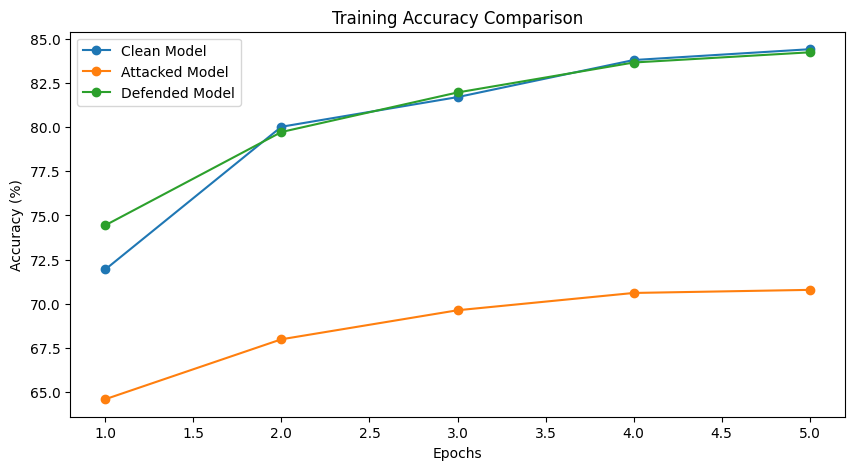

In [7]:
print("Training the clean model...")
clean_model = utils_a.CNN(num_classes=4).to(device)
state_dict = torch.load('weights/cnn_10epochs.pth', map_location=device, weights_only=True)
clean_model.load_state_dict(state_dict)
clean_optimizer = optim.Adam(clean_model.parameters(), lr=0.0001, weight_decay=1e-5)
clean_accuracies = train_and_evaluate(clean_model, clean_optimizer, train_loader, test_loader, "clean", num_epochs)

print("Training the model attacked with DrunkOptimizer...")
attacked_model = utils_a.CNN(num_classes=4).to(device)
attacked_model.load_state_dict(state_dict)
base_optimizer = optim.Adam(attacked_model.parameters(), lr=0.0001, weight_decay=1e-5)
drunk_optimizer = DrunkOptimizer(
    attacked_model.parameters(),
    base_optimizer=base_optimizer,
    scale_strength=0.7,  # Potenziato
    perturb_strength=0.7,  # Potenziato
    attack_type='combined'
)
attacked_accuracies = train_and_evaluate(attacked_model, drunk_optimizer, train_loader, test_loader, "attacked", num_epochs)

print("Training the model with defense techniques...")
defended_model = utils_a.CNN(num_classes=4).to(device)
defended_model.load_state_dict(state_dict)
defense_optimizer = optim.Adam(defended_model.parameters(), lr=0.0001, weight_decay=1e-5)
defended_accuracies = train_and_evaluate(defended_model, defense_optimizer, train_loader, test_loader, "defended", num_epochs, adv_training=True)

# Plotting all accuracies together
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), clean_accuracies, marker='o', label='Clean Model')
plt.plot(range(1, num_epochs + 1), attacked_accuracies, marker='o', label='Attacked Model')
plt.plot(range(1, num_epochs + 1), defended_accuracies, marker='o', label='Defended Model')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()